# ALS transect 3D visualization

This notebook illustrates transect visualization using CVL 3D Viz software


## Objectives

Demonstrate visualization of X,Y,Z timeseries together with the Sentinel-1 image as background

## Prerequisites

Software prerequisites
- pip3
- cvl 3d viz library
- requests

System libraries not provided via CVL have been installed using conda/mamba package manager.

Install CVL 3D viz library for steering the visualization in-browser app 


```
# Use preceeding exclamation mark if installing from within the notebook, othewise add URL below to requirements file
!pip3 install git+https://github.com/CryosphereVirtualLab/cvl-3d-viz#egg=cvl-3d-viz
```


In [58]:
!pip3 install git+https://github.com/CryosphereVirtualLab/cvl-3d-viz#egg=cvl-3d-viz > /dev/null 2>&1

## Starting CVL 3d Viz server
The server is necessary to communicate between the notebook and the browser application. The server needs to be available, configured and running locally.


In [33]:
# Obtain 3d viz server code
# !if [ ! -d ~/cvl-3d-viz ]; then git clone https://github.com/CryosphereVirtualLab/cvl-3d-viz.git ~/cvl-3d-viz ; fi
# import os
import subprocess
subprocess.Popen("cd ~/cvl-3d-viz && nohup python3 cvl/server.py > /dev/null 2>&1 &", shell=True)

<Popen: returncode: None args: 'cd ~/cvl-3d-viz && nohup python3 cvl/server....>

In [34]:
from cvl.viz import viz, VBO, Raster
visualizer = viz()
visualizer.look_at([70, 70, 5000], [1, 69.673, 0], 100)

# Input data

Data series come in tabular format and represent geographical coordinates and height. Data are hosted at Zenodo and need to be cached locally before executing the rest of the playbook. Additionally Sentinel-1 scenes are used as a background and those are added

We will pull the data zip file using requests library and unpack it locally for further use.

In [35]:
import zipfile, io, requests

url = "https://zenodo.org/record/7582591/files/MOSAiC_subset_for_CVL.zip?download=1"
# r = requests.get(url)
# z = zipfile.ZipFile(io.BytesIO(r.content))
# z.extractall("data")

#  Load measurements as Geopandas DataFrame
Here our approach is to use pandas to load data from the CSV file we obtained earlier. Once the series are loaded we create geopandas data frame object which add geospatial dimension to the series by creating geometry column.

Geopandas provides methods for casting the geometry information into the desired coordinate system/projection. Here we use UTM 33N, as it is used in the original CVL 3D viz example notebook.

In [36]:
import pandas
df = pandas.read_csv("data/transect_latlon.txt", header=0)

In [37]:
import geopandas as gpd
# Create a geometry aware Geopandas DataFrame object 
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Lon, df.Lat),
    crs=4326
).to_crs(32633)


           Lon        Lat           X           Y  thickness  \
0     0.026922  79.999070  522.158846 -103.727231       10.0   
1     0.026860  79.999059  520.958814 -104.982105       10.0   
2     0.026831  79.999054  520.387532 -105.492390       10.0   
3     0.026780  79.999042  519.409398 -106.862337       10.0   
4     0.026731  79.999031  518.460868 -108.046150       10.0   
...        ...        ...         ...         ...        ...   
1080  0.027273  79.999087  528.971526 -101.861249       10.0   
1081  0.027218  79.999089  527.898476 -101.553523       10.0   
1082  0.027187  79.999090  527.299539 -101.460733       10.0   
1083  0.026958  79.999105  522.857436  -99.835732       10.0   
1084  0.026871  79.999127  521.159618  -97.345641       10.0   

                            geometry  
0     POINT (212809.298 8918661.977)  
1     POINT (212807.817 8918661.069)  
2     POINT (212807.134 8918660.722)  
3     POINT (212805.838 8918659.646)  
4     POINT (212804.618 8918658.743)

# Plot data using 3D Viz

Functions below are taken from the original 3D viz example notebook. Alternative would be to generate a geojson object since 3D viz has methods for processing geojson files/objects.

In [38]:
# This function was taken from the 3D Viz example notebook
def post_3d_data(key, primitive, vertices, color=None, texcoord=None, normal=None, index=None, texture=None, compute_normals=False):
    # metadata = { "path" : "Examples", "time_start" : time.time()-601, "time_stop" : time.time()-601 }
    metadata = { "path" : "Examples" }
    vbo = VBO(primitive, projection=32633)
    vbo.compute_normals = compute_normals
    vbo.set_vertex(vertices)
    vbo.set_color(color)
    vbo.set_texcoord(texcoord)
    vbo.set_normal(normal)
    vbo.set_index(index)
    vbo.texture = texture
    visualizer.publish_vbo(key, metadata, vbo)

In [59]:
# This cell is work in progress

import numpy as np
import math

points = np.array([x for x in zip(gdf.geometry.x, gdf.geometry.y, gdf.thickness) ])
colors = np.ones((points.shape[0],4), dtype=np.uint32) * (255, 255, 255, 255)
vcolors = np.array([VBO.rgb_to_color(x[0], x[1], x[2], x[3]) for x in colors], dtype=np.uint32)

# Post transect data as points to web app
post_3d_data("Transect points", "points", points, vcolors)

origin = np.array((509389, 8686070, 700)) # The origin is in UTM 33.

def gen_index(width, height):
    verts_per_line = 2*width
    tris_per_line = verts_per_line-2
    num_tris = tris_per_line*(height-1)
    num_index = num_tris*3
    indices = np.zeros((num_index), dtype=np.uint32)
    idx = 0
    for y in range(0, height-1):
        for x in range(0, width-1):
            indices[idx+0]	= ((y+1) * width) + x
            indices[idx+1]	= (y*width)+x
            indices[idx+2]	= (y*width)+x+1
            indices[idx+3]	= (y*width)+x+1
            indices[idx+4]	= ((y+1) * width) + x+1
            indices[idx+5]	= ((y+1) * width) + x
            idx += 6
    return indices


points = np.zeros((4, 3), dtype=np.float64)
colors = np.zeros((4), dtype=np.uint32)
points[0] = origin
points[1] = origin+[1000, 0, 0]
points[2] = origin+[1000, 1000, 0]
points[3] = origin+[0, 1000, 0]
colors[0] = 0xffffffff
colors[1] = 0xffffffff
colors[2] = 0xffffffff
colors[3] = 0xffffffff

post_3d_data("Example lines", "lineloop", points, colors)

# Note that the ordering of the points is different here, compared to the lines above.
points[0] = origin
points[1] = origin+[1000, 0, 0]
points[2] = origin+[0, 1000, 0]
points[3] = origin+[1000, 1000, 0]

texcoords = np.zeros((4, 2), dtype=np.float32)
texcoords[0] = [0, 0]
texcoords[1] = [1, 0]
texcoords[2] = [0, 1]
texcoords[3] = [1, 1]
index = gen_index(2,2)

with open("cvl-3d-viz/notebooks/texture.jpg", "rb") as fd:
    texture = fd.read()

post_3d_data("Example texture", "triangles", points+[1200,0,0], None, texcoord=texcoords, index=index, texture=texture)


## Screenshot from 3D Viz with the result

Picture below illustrates the results of plotting the transect points data. Points have 3 dimensions and when zooming in a difference in height is noticeable.

![title](./screenshot.png)

# Load Sentinel 1 satellite data

The search for data has been done using satellittdata.no data portal. Once the scene is found, we load a subset via OpenDAP protocol using xarray library. We load amplitude values of HH channel and sigmaNought calibration array. `hh` array contains the product of two.

In [43]:
# Work in progress
import netCDF4
import xarray

dst = xarray.open_dataset("https://nbstds.met.no/thredds/dodsC/NBS/S1A/2020/03/13/EW/S1A_EW_GRDM_1SDH_20200313T074514_20200313T074618_031654_03A60C_C1D9.nc")
hh = dst["sigmaNought_HH"][0,1000:2000,1000:2000] * dst["Amplitude_HH"][0,1000:2000,1000:2000]
lat = dst["lat"][0,1000:2000,1000:2000]
lon = dst["lon"][0,1000:2000,1000:2000]

Frozen({'time': <xarray.IndexVariable 'time' (time: 1)>
array(['2020-03-13T07:45:14.000000000'], dtype='datetime64[ns]')
Attributes:
    long_name:  reference time of satellite image, 'lat': <xarray.Variable (y: 10707, x: 10507)>
[112498449 values with dtype=float32]
Attributes:
    standard_name:  latitude
    units:          degrees_north
    long_name:      latitude
    _ChunkSizes:    [31 33], 'lon': <xarray.Variable (y: 10707, x: 10507)>
[112498449 values with dtype=float32]
Attributes:
    units:          degrees_east
    standard_name:  longitude
    long_name:      longitude
    _ChunkSizes:    [31 33], 'Amplitude_HH': <xarray.Variable (time: 1, y: 10707, x: 10507)>
[112498449 values with dtype=float32]
Attributes:
    long_name:      Amplitude HH-polarisation
    units:          1
    grid_mapping:   crsWGS84
    standard_name:  surface_backwards_scattering_coefficient_of_radar_wave
    polarisation:   HH
    _ChunkSizes:    [ 1 31 33], 'Amplitude_HV': <xarray.Variable (time: 

IndexError: too many indices

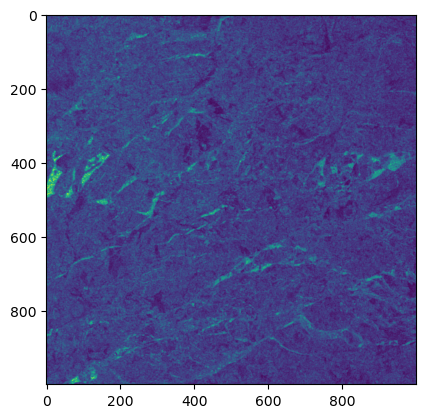

In [44]:
# This cell is work in progress. It illustrates the calibrated Sentinel-1 HH measurements

%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(hh)
plt.show()